# Explore latent space features
We want to know if our VAE model is capturing our signal

Identify high weight (HW) genes for each latent space feature (node)
Determine if genes in group A and B are found within these highly weighted genes

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


randomState = 123
from numpy.random import seed
seed(randomState)

In [2]:
# Load arguments
analysis_name = "sim_balancedAB_2latent"
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "VAE_weight_matrix.txt")
A_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetA.txt")
B_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetB.txt")

#HW_file = os.path.join(os.path.dirname(os.getcwd()), "output", analysis_name, "HW_genes.txt")

In [3]:
# Read in data
geneSetA = pd.read_table(A_file, header=0, index_col=0)
geneSetB = pd.read_table(B_file, header=0, index_col=0)

weight = pd.read_table(data_file, header=0, index_col=0).T
weight.head(5)

,0,1
PA3423,0.400786,0.390443
PA0084,0.401404,0.394910
PA2455,0.405950,0.400744
PA3029,0.404776,0.384604
PA1588,0.393269,0.393151


In [4]:
# Plot the distribution of gene weights per latent feature
#num_features = weight.shape[1]

#f, axes = plt.subplots(num_features, 1, sharex=True)
#for i, ax in zip(weight.columns, axes.flat):
#    sns.distplot(weight[i] , color="skyblue", rug=False, kde=False, ax=ax)
    
#f.set_size_inches(15, 15)

In [5]:
# Calculate mean per node ("signature" or "feature")
means = weight.mean(axis=0)

# Calculate 2 standard deviations per node ("signature" or "feature")
stds = weight.std(axis=0)
two_stds = 2*stds

In [6]:
# Get high positive and negative weight genes per node ("signature" or "feature") -- HW_df
# Record metadata per latent feature in a table -- HW_metadata_df
# Record distance between gene set weight and 
HW_df = pd.DataFrame()
HW_metadata_df = pd.DataFrame()

num_nodes = len(means)

for i in range(num_nodes):
    node_mean = means.iloc[i]
    node_std = stds.iloc[i] 
    
    pos_threshold = node_mean + two_stds.iloc[i]
    neg_threshold = node_mean - two_stds.iloc[i]
    
    hw_pos_genes = weight[weight[i] > pos_threshold].index
    hw_neg_genes = weight[weight[i] < neg_threshold].index
    
    node = str(i)
    node_name = 'Sig'+node+'pos'
    
    # Add high weight positive genes
    add_pos = pd.DataFrame({node_name: list(hw_pos_genes)})
    HW_df = pd.concat([HW_df, add_pos], axis=1)
    
    # Add metadata for positive node
    add_metadata_pos = pd.DataFrame({node_name: [node_mean, node_std, pos_threshold]})
    HW_metadata_df = pd.concat([HW_metadata_df, add_metadata_pos], axis=1)
    
    # Add high weight negative genes
    node_name = 'Sig'+node+'neg'
    
    add_neg = pd.DataFrame({node_name: list(hw_neg_genes)})
    HW_df = pd.concat([HW_df, add_neg], axis=1)
    
    # Add metadata for negative node
    add_metadata_neg = pd.DataFrame({node_name: [node_mean, node_std, neg_threshold]})
    HW_metadata_df = pd.concat([HW_metadata_df, add_metadata_neg], axis=1)

HW_df = HW_df.T
HW_metadata_df = HW_metadata_df.T

In [7]:
HW_df.head()

,0,1,2
Sig0pos,NaN,NaN,NaN
Sig0neg,PA2208,PA0886,PA1979
Sig1pos,NaN,NaN,NaN
Sig1neg,PA4846,PA4740,PA0595


In [8]:
# Dataframe with the mean, std, threshold used per feature to determine high weight gene sets
HW_metadata_df.columns = ["mean", "std", "threshold"]
HW_metadata_df.head()

,mean,std,threshold
Sig0pos,0.273938,0.145629,0.565195
Sig0neg,0.273938,0.145629,-0.017319
Sig1pos,0.259776,0.140563,0.540901
Sig1neg,0.259776,0.140563,-0.021349


In [9]:
# Create a table (feature x gene set A)
# Each cell will contain the distance between the weight and the mean

Weights_pos_neg_df = pd.DataFrame()

for i in range(num_nodes):
    node_mean = means.iloc[i]
    
    node = str(i+1)
    node_name = 'Sig'+node+'pos'
    
    gene_weight = weight[i]
    
    # Add high weight positive genes
    add_pos = pd.DataFrame({node_name: gene_weight})
    Weights_pos_neg_df = pd.concat([Weights_pos_neg_df, add_pos], axis=1)
    
    # Add high weight negative genes
    node_name = 'Sig'+node+'neg'
    
    add_neg = pd.DataFrame({node_name: gene_weight})
    Weights_pos_neg_df = pd.concat([Weights_pos_neg_df, add_neg], axis=1)
    
    
Weights_pos_neg_df = Weights_pos_neg_df.T
Weights_pos_neg_df.head()

,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA5348,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776
Sig1pos,0.400786,0.401404,0.405950,0.404776,0.393269,0.398822,0.403839,0.399343,0.418950,0.406352,...,0.325048,0.009685,0.02904,0.043815,0.124002,0.202072,0.187087,0.106031,0.432988,0.167887
Sig1neg,0.400786,0.401404,0.405950,0.404776,0.393269,0.398822,0.403839,0.399343,0.418950,0.406352,...,0.325048,0.009685,0.02904,0.043815,0.124002,0.202072,0.187087,0.106031,0.432988,0.167887
Sig2pos,0.390443,0.394910,0.400744,0.384604,0.393151,0.385771,0.387592,0.386408,0.387678,0.396522,...,0.153105,0.186168,0.17840,0.121395,0.130280,0.076797,0.108551,0.095826,0.066934,0.041843
Sig2neg,0.390443,0.394910,0.400744,0.384604,0.393151,0.385771,0.387592,0.386408,0.387678,0.396522,...,0.153105,0.186168,0.17840,0.121395,0.130280,0.076797,0.108551,0.095826,0.066934,0.041843


In [10]:
# Compare the weights for geneset A with threshold
geneSetA_ls = [l[0] for l in geneSetA.values.tolist()]
Weight_A = Weights_pos_neg_df[geneSetA_ls]

Weight_A.head()

,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA5556,PA0593,PA0204,PA3744,PA0822,PA2525,PA0014,PA1626,PA2274,PA3080
Sig1pos,0.400786,0.401404,0.405950,0.404776,0.393269,0.398822,0.403839,0.399343,0.418950,0.406352,...,0.399329,0.392381,0.394732,0.408281,0.409553,0.399727,0.395955,0.399538,0.410195,0.395376
Sig1neg,0.400786,0.401404,0.405950,0.404776,0.393269,0.398822,0.403839,0.399343,0.418950,0.406352,...,0.399329,0.392381,0.394732,0.408281,0.409553,0.399727,0.395955,0.399538,0.410195,0.395376
Sig2pos,0.390443,0.394910,0.400744,0.384604,0.393151,0.385771,0.387592,0.386408,0.387678,0.396522,...,0.400375,0.402207,0.383567,0.390523,0.398196,0.398890,0.392312,0.398245,0.391593,0.393096
Sig2neg,0.390443,0.394910,0.400744,0.384604,0.393151,0.385771,0.387592,0.386408,0.387678,0.396522,...,0.400375,0.402207,0.383567,0.390523,0.398196,0.398890,0.392312,0.398245,0.391593,0.393096


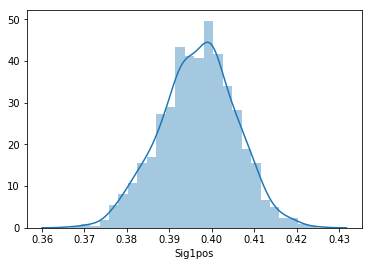

In [11]:
sns.distplot(Weight_A.iloc[0])

In [12]:
# Compare the weights for geneset B with threshold
geneSetB_ls = [l[0] for l in geneSetB.values.tolist()]
Weight_B = Weights_pos_neg_df[geneSetB_ls]

Weight_B.head()

,PA0308,PA2691,PA3664,PA0069,PA4467,PA4255,PA5157,PA4881,PA0128,PA5140,...,PA5348,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776
Sig1pos,0.176398,0.076403,0.325139,0.051439,0.000997,0.378818,0.081581,0.136445,0.126141,0.205700,...,0.325048,0.009685,0.02904,0.043815,0.124002,0.202072,0.187087,0.106031,0.432988,0.167887
Sig1neg,0.176398,0.076403,0.325139,0.051439,0.000997,0.378818,0.081581,0.136445,0.126141,0.205700,...,0.325048,0.009685,0.02904,0.043815,0.124002,0.202072,0.187087,0.106031,0.432988,0.167887
Sig2pos,0.150507,0.122821,0.083499,0.095599,0.184742,-0.009466,0.091484,0.086343,0.128977,0.060793,...,0.153105,0.186168,0.17840,0.121395,0.130280,0.076797,0.108551,0.095826,0.066934,0.041843
Sig2neg,0.150507,0.122821,0.083499,0.095599,0.184742,-0.009466,0.091484,0.086343,0.128977,0.060793,...,0.153105,0.186168,0.17840,0.121395,0.130280,0.076797,0.108551,0.095826,0.066934,0.041843


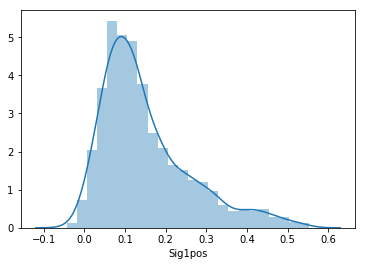

In [13]:
sns.distplot(Weight_B.iloc[0])

In [14]:
# What is the overlap between the high weight genes and gene sets A and B?
num_A = geneSetA.shape[0]
num_B = geneSetB.shape[0]

num_features_pos_neg = HW_df.shape[0]

percent_overlap = pd.DataFrame({'feature': [], 
                                'percent in A': [],
                                'percent in B': []
                               })

for i in range(num_features_pos_neg):
#for i in range(2):
    row = HW_df.iloc[i]
    percent_in_A = (row.isin(geneSetA_ls).sum()/num_A)*100
    percent_in_B = (row.isin(geneSetB_ls).sum()/num_B)*100
    
    add = pd.DataFrame({'feature': [HW_df.index[i]],
                        'percent in A': [percent_in_A],
                        'percent in B': [percent_in_B]
                       })
    percent_overlap = percent_overlap.append(add)

percent_overlap

,feature,percent in A,percent in B
0,Sig0pos,0.0,0.0
0,Sig0neg,0.0,0.3
0,Sig1pos,0.0,0.0
0,Sig1neg,0.0,0.3


In [15]:
# Are there any features that are nonzero?
overlap_in_A = percent_overlap.iloc[percent_overlap["percent in A"].nonzero()[0]]
overlap_in_B = percent_overlap.iloc[percent_overlap["percent in B"].nonzero()[0]]

print(overlap_in_A.shape)
print(overlap_in_B.shape)
overlap_in_A

(0, 3)
(2, 3)


,feature,percent in A,percent in B


In [16]:
overlap_in_B

,feature,percent in A,percent in B
0,Sig0neg,0.0,0.3
0,Sig1neg,0.0,0.3
